### Imported Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib
import multiprocessing
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

### Feature Extraction Functions

In [2]:
beta = pd.read_feather("beta/betas_condensed.fth")
spread_dom = pd.read_csv("all_times.csv").drop(["beta"],axis=1)

def mad(data):
    return np.mean(np.absolute(data - np.mean(data)))

def import_beta(df):
    global beta
    global spread_dom
    
    df = pd.merge(df, beta, how="left")
    df = pd.merge(df, spread_dom, how="left")
    return df
    
def compute_wap(df):
    return (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) \
          /(df['bid_size1'] + df['ask_size1'])

def compute_wap2(df):
    return (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) \
           /(df['bid_size2'] + df['ask_size2'])

def compute_dom(df):
    dom = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            + (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])
    return dom

def compute_dom_diff(df):
    dom_diff = abs((df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            - (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2']))
    return dom_diff

def fill_seconds(df):
    df = df.reset_index(drop=True)
    index_range = pd.Index(range(600), name='seconds_in_bucket')
    df = df.set_index('seconds_in_bucket').reindex(index_range)
    
    # Forward fill & back fill seconds
    df = df.ffill().reset_index()
    return df.bfill().iloc[:600]

def beta_encoding(df):
    beta1 = np.repeat(np.nan, df.shape[0])
    beta2 = np.repeat(np.nan, df.shape[0])
    kf = KFold(n_splits = 112, shuffle=True,random_state = 0)
    for idx_1, idx_2 in kf.split(df):
        bmean1 = df.iloc[idx_1].groupby('stock_id')['beta'].mean()
        bmean2 = df.iloc[idx_1].groupby('stock_id')['beta2'].mean()
        beta1[idx_2] = df['stock_id'].iloc[idx_2].map(bmean1)
        beta2[idx_2] = df['stock_id'].iloc[idx_2].map(bmean2)
        
    df['encode_mean_beta'] = beta1
    df['encode_mean_beta2'] = beta2
    
    return df.drop(['beta','beta2'], axis=1)

def target_encoding(df):
    tenc = np.repeat(np.nan, df.shape[0])
    senc = np.repeat(np.nan, df.shape[0])
    denc = np.repeat(np.nan, df.shape[0])
    tencs = np.repeat(np.nan, df.shape[0])
    sencs = np.repeat(np.nan, df.shape[0])
    dencs = np.repeat(np.nan, df.shape[0])
    kf = KFold(n_splits = 112, shuffle=True,random_state = 0)
    for idx_1, idx_2 in kf.split(df):
        tmean = df.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].mean()
        smean = df.iloc[idx_1].groupby('stock_id')['spread'].mean()
        dmean = df.iloc[idx_1].groupby('stock_id')['dom'].mean()
        tmeans = df.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].std()
        smeans = df.iloc[idx_1].groupby('stock_id')['spread'].std()
        dmeans = df.iloc[idx_1].groupby('stock_id')['dom'].std()
        tenc[idx_2] = df['stock_id'].iloc[idx_2].map(tmean)
        senc[idx_2] = df['stock_id'].iloc[idx_2].map(smean)
        denc[idx_2] = df['stock_id'].iloc[idx_2].map(dmean)
        tencs[idx_2] = df['stock_id'].iloc[idx_2].map(tmeans)
        sencs[idx_2] = df['stock_id'].iloc[idx_2].map(smeans)
        dencs[idx_2] = df['stock_id'].iloc[idx_2].map(dmeans)
    df['target_mean_enc'] = tenc
    df['spread_mean_enc'] = senc
    df['dom_mean_enc'] = denc
    df['target_std_enc'] = tencs
    df['spread_std_enc'] = sencs
    df['dom_std_enc'] = dencs
    
    return df.drop(['dom','spread'], axis=1)

def generate_feature_seconds(features, df, feats, seconds=[300], overlap=1):
    if overlap:
        for second in seconds:
            res = pd.DataFrame(
                df.query(f'{seconds[0]-second} <= seconds_in_bucket < {seconds[0]}')
                .groupby(['time_id']).agg(feats)
            ).reset_index()
            res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
            res = res.add_suffix('_' + str(second))
            features = pd.merge(
                features, res, 
                how='left', 
                left_on='time_id', 
                right_on=f'time_id_{second}'
            )
            features = features.drop([f'time_id_{second}'], axis=1)  
    else:
        for i, second in enumerate(seconds):
            last_second = 0 if not i else seconds[i-1]
            res = pd.DataFrame(
                df.query(f'{last_second} <= seconds_in_bucket < {second}')
                .groupby(['time_id']).agg(feats)
            ).reset_index()
            res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
            res = res.add_suffix('_' + str(second))
            features = pd.merge(
                features, res, 
                how='left', 
                left_on='time_id', 
                right_on=f'time_id_{second}'
            )
            features = features.drop([f'time_id_{second}'], axis=1)
    return features

def generate_target(df, target, second=300):
    features = pd.DataFrame(
        df.query(f'seconds_in_bucket >= {second}')
        .groupby(['time_id']).agg(target)
    ).reset_index()
    features.columns = ['_'.join(feat).rstrip('_') for feat in features.columns]
    return features

def calc_slope(df):
    v0 = (df['bid_size1']+df['ask_size1'])/2
    p0 = (df['bid_price1']+df['ask_price1'])/2
    slope_bid = ((df['bid_size1']/v0)-1)/abs((df['bid_price1']/p0)-1)+(
                (df['bid_size2']/df['bid_size1'])-1)/abs((df['bid_price2']/df['bid_price1'])-1)
    slope_ask = ((df['ask_size1']/v0)-1)/abs((df['ask_price1']/p0)-1)+(
                (df['ask_size2']/df['ask_size1'])-1)/abs((df['ask_price2']/df['ask_price1'])-1)
    return (slope_bid+slope_ask)/2, abs(slope_bid-slope_ask)


def calc_dispersion(df):
    bspread = df['bid_diff']
    aspread = df['ask_diff']
    bmid = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price1']
    bmid2 = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price2']
    amid = df['ask_price1'] - (df['bid_price1'] + df['ask_price1'])/2
    amid2 = df['ask_price2'] - (df['bid_price1'] + df['ask_price1'])/2
    bdisp = (df['bid_size1']*bmid + df['bid_size2']*bspread)/(df['bid_size1']+df['bid_size2'])
    bdisp2 = (df['bid_size1']*bmid + df['bid_size2']*bmid2)/(df['bid_size1']+df['bid_size2'])
    adisp = (df['ask_size1']*amid + df['ask_size2']*aspread)/(df['ask_size1']+df['ask_size2'])      
    adisp2 = (df['ask_size1']*amid + df['ask_size2']*amid2)/(df['ask_size1']+df['ask_size2'])
    return (bdisp + adisp)/2, (bdisp2 + adisp2)/2

def calc_price_impact(df):
    ask = (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])/(df['ask_size1']+df['ask_size2'])
    bid = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'])/(df['bid_size1']+df['bid_size2'])
    return (df['ask_price1'] - ask)/df['ask_price1'], (df['bid_price1'] - bid)/df['bid_price1']


def calc_ofi(df):
    a = df['bid_size1']*np.where(df['bid_price1'].diff()>=0,1,0)
    b = df['bid_size1'].shift()*np.where(df['bid_price1'].diff()<=0,1,0)
    c = df['ask_size1']*np.where(df['ask_price1'].diff()<=0,1,0)
    d = df['ask_size1'].shift()*np.where(df['ask_price1'].diff()>=0,1,0)
    return a - b - c + d

def calc_tt1(df):
    p1 = df['ask_price1'] * df['ask_size1'] + df['bid_price1'] * df['bid_size1']
    p2 = df['ask_price2'] * df['ask_size2'] + df['bid_price2'] * df['bid_size2']      
    return p2 - p1 

def log_returns(waps):
    return np.log(waps).diff() 

def realized_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2))

def weighted_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2)/log_returns.count())

def quarticity(s):
    return (s.count()/3) * np.sum(s**4)

### Generate Features for First 5 Minutes of Each Stock 

In [3]:
def concat_features(stock_id, df):
    file = f"extend_three/stock_{stock_id}.fth"        
    return pd.concat([df, generate_features(file)])

def process_stocks(stock_ids):
    df = pd.DataFrame()
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(concat_features)(stock_id, df) for stock_id in stock_ids
    )
    df = pd.concat(df, ignore_index = True)
    
    # lastly import pre-computed beta coefficients for all stock_ids
    df = import_beta(df)
    df = target_encoding(df)
    df = beta_encoding(df)
    return df

def generate_features(file_path):
    df = pd.read_feather(file_path)
    
    # compute waps for first and second ask/bids 
    df['wap'] = compute_wap(df)
    df['wap2'] = compute_wap2(df)
    
    # compute log returns for realized volatility
    df['log_returns'] = df.groupby('time_id')['wap'].apply(log_returns)
    df['log_returns2'] = df.groupby('time_id')['wap2'].apply(log_returns)
    
    # compute difference in waps and price as feature
    df['wap_diff'] = abs(df['wap'] - df['wap2'])
    
    # price difference regularized
    df['price_diff'] = (df['ask_price1'] - df['bid_price1']) \
                        / ((df['ask_price1'] + df['bid_price1'])/2)
    df['price_diff2'] = (df['ask_price2'] - df['bid_price2']) \
                        / ((df['ask_price2'] + df['bid_price2'])/2)
    
    # difference between first and second bid/ask price
    df['bid_diff'] = df['bid_price1'] - df['bid_price2']
    df['ask_diff'] = df['ask_price1'] - df['ask_price2']
    
    # sum of first and second ask sizes and bid sizes
    df['bid_ask_volume'] = (df['ask_size1'] + df['ask_size2']) \
                        + (df['bid_size1'] + df['bid_size2'])
    
    # diff between ask sizes and bid sizes 
    df['bid_ask_volume_diff'] = abs((df['ask_size1'] + df['ask_size2']) \
                                - (df['bid_size1'] + df['bid_size2']))

    # depth of market and difference
    df['dom'] = compute_dom(df)
    df['dom_diff'] = compute_dom_diff(df)
    df['dom_imbalance'] = abs(df['dom'] - df['dom_diff'])
    
    # bid ask spread from lecture/lab
    df["bid_ask_spread1"] = df['ask_price1'] / df['bid_price1'] - 1
    df["bid_ask_spread2"] = df['ask_price2'] / df['bid_price2'] - 1
    df['bid_ask_spread3'] = abs(df['bid_diff'] - df['ask_diff'])
    
    df["slope"], _ = calc_slope(df)
    df["dispersion"], _ = calc_dispersion(df)
    df["price_impact"], _ = calc_price_impact(df)
    df["ofi"] = calc_ofi(df)
    df["turn_over"] = calc_tt1(df)   
    
    df['target'] =  df.groupby('time_id')['wap'].apply(log_returns)
    
    target_dict = {'target':[realized_volatility]}
    feature_dict = {
        'wap':[np.mean, np.std],#, mad, np.max, np.sum],
        'wap2':[np.mean, np.std],#, mad, np.max, np.sum],
        'log_returns':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean],# np.std, np.max],
        'log_returns2':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean],# np.std, np.max],
        'wap_diff':[np.std, np.max],#, mad, np.max, np.sum],
        'price_diff':[np.max, np.std], #np.max, np.sum],#, mad, np.max, np.sum],
        'price_diff2':[np.max, np.std],#, np.max, np.sum],#, mad, np.max, np.sum],
        'bid_diff':[np.max, np.std],#, np.max, np.sum],#, mad, np.max, np.sum],
        'ask_diff':[np.max, np.std],#, np.max, np.sum],#, mad, np.max, np.sum],
        'bid_ask_volume':[np.mean, np.std, np.max],#, np.sum],#, mad, np.max, np.sum],
        'bid_ask_volume_diff':[np.mean, np.max],#, mad, np.max, np.sum],
        'dom':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'dom_diff':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'dom_imbalance':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'bid_ask_spread1':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread2':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread3':[np.mean, np.std],#, mad, np.max, np.sum],
        'slope':[np.mean, np.max, np.std],#, mad, np.max, np.sum],
        'dispersion':[np.mean, np.max],#, mad, np.max, np.sum],
        'price_impact':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'ofi':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'turn_over':[np.mean, np.std, np.max]#, mad, np.max, np.sum],
    }
    
    # target realized volatility for next 300 second (5 min window in time_id)
    feature = generate_target(
        df, target=target_dict, 
        second=1500  # target volatility is for next 300 second (no overlap)
    )
    
    # obtain features over entire 5 mins or last 2.5 mins..
    
    feature = generate_feature_seconds(
        feature, df, 
        feats=feature_dict, 
        seconds=[1500, 1200, 900, 600, 300, 150],  # features generated for each second interval (different widths)
        overlap=1,
    )

    #create stock_id
    feature['stock_id'] = int(file_path.split('/')[1].split('_')[1].split('.')[0])
    feature['time_id'] = feature['time_id'].apply(int)
    
    return feature

## Process Features for All Stocks

In [4]:
all_stocks = process_stocks(beta.stock_id.unique())
all_stocks

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 13.4min finished


,time_id,target_realized_volatility,wap_mean_1500,wap_std_1500,wap2_mean_1500,wap2_std_1500,log_returns_realized_volatility_1500,log_returns_weighted_volatility_1500,log_returns_quarticity_1500,log_returns_mean_1500,...,beta-300,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2
0,5,0.002954,194.207301,0.412362,194.185826,0.411203,0.006052,0.000156,2.365591e-08,2.079061e-06,...,0.737558,0.778640,0.003206,0.001129,393.634604,0.002476,0.001086,104.607738,0.641185,0.643615
1,16,0.001295,209.490866,0.304750,209.520266,0.311566,0.006275,0.000162,1.850904e-07,-5.351557e-07,...,4.284855,1.519335,0.003200,0.001127,393.685459,0.002468,0.001083,104.553561,0.637365,0.639117
2,72,0.006357,191.694104,0.341674,191.676459,0.363077,0.009231,0.000238,2.332238e-07,-2.438174e-06,...,0.138981,-0.628995,0.003197,0.001124,393.299908,0.002460,0.001076,104.548907,0.642328,0.645247
3,146,0.002993,192.590204,0.571536,192.573690,0.582518,0.016735,0.000432,3.273346e-06,1.901837e-06,...,1.343053,1.346464,0.003188,0.001123,392.851071,0.002451,0.001079,104.193461,0.642136,0.643610
4,207,0.004958,195.645764,0.707870,195.645380,0.724665,0.015073,0.000389,1.343222e-06,-2.484235e-06,...,0.955366,1.050217,0.003203,0.001128,393.313587,0.002475,0.001083,104.543486,0.644569,0.646144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195323,32746,0.010431,298.914467,2.550301,298.935256,2.557943,0.021235,0.000548,1.208900e-05,-1.515451e-05,...,6.684690,5.846123,0.004151,0.001185,386.339411,0.002751,0.000884,94.618436,1.009772,1.002771
195324,32748,0.003057,190.936593,1.287406,190.940818,1.278707,0.014666,0.000379,1.152862e-05,1.461767e-05,...,3.532491,4.055885,0.004164,0.001191,386.124680,0.002755,0.000888,94.654292,1.009268,1.003451
195325,32751,0.002899,308.503293,0.948447,308.557724,0.959964,0.009657,0.000249,8.553256e-07,-5.627314e-06,...,3.484390,1.049953,0.004162,0.001189,386.227392,0.002749,0.000886,94.737774,1.015962,1.010063
195326,32758,0.002792,200.280576,2.205298,200.271309,2.242222,0.032255,0.000833,2.561434e-04,5.391341e-06,...,-0.570789,-0.046489,0.004155,0.001188,385.895099,0.002747,0.000885,94.208646,1.014303,1.006423


In [5]:
all_stocks = all_stocks.reset_index(drop=True)
all_stocks.memory_usage()

Index                             128
time_id                       1562624
target_realized_volatility    1562624
wap_mean_1500                 1562624
wap_std_1500                  1562624
                               ...   
target_std_enc                1562624
spread_std_enc                1562624
dom_std_enc                   1562624
encode_mean_beta              1562624
encode_mean_beta2             1562624
Length: 350, dtype: int64

In [6]:
del beta
del spread_dom  # don't need in memory anymore

### Rows with NaN are timeIDs that do not have extend2 chains
We will remove these rows as well

In [7]:
all_stocks[all_stocks.isna().any(axis=1)]

,time_id,target_realized_volatility,wap_mean_1500,wap_std_1500,wap2_mean_1500,wap2_std_1500,log_returns_realized_volatility_1500,log_returns_weighted_volatility_1500,log_returns_quarticity_1500,log_returns_mean_1500,...,beta-300,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2
48852,438,0.0,6.440557,0.022097,6.443456,0.025072,0.008327,0.000240,1.471518e-06,4.142061e-06,...,0.0,0.0,0.002822,0.001217,166757.098403,0.002007,0.000329,117674.505312,0.021510,0.023328
48877,985,0.0,6.183158,0.024283,6.185483,0.026546,0.009493,0.000274,9.705579e-08,6.903043e-06,...,0.0,0.0,0.002827,0.001216,166348.760480,0.002011,0.000329,117738.605809,0.021945,0.023752
48920,1826,0.0,6.867724,0.005706,6.870562,0.007929,0.004139,0.000120,1.391888e-08,1.635193e-06,...,0.0,0.0,0.002828,0.001217,166630.247034,0.002005,0.000329,117669.963352,0.021565,0.023422
48949,2254,0.0,6.501211,0.005272,6.501541,0.007937,0.002233,0.000091,1.724834e-09,-1.981966e-07,...,0.0,0.0,0.002833,0.001216,165888.033219,0.002008,0.000329,117499.250214,0.021698,0.023422
48950,2267,0.0,6.052554,0.018030,6.053542,0.018795,0.007187,0.000208,5.920132e-07,-1.536842e-06,...,0.0,0.0,0.002831,0.001217,166217.059955,0.002008,0.000329,117474.474787,0.021434,0.023385
48977,2891,0.0,11.866151,0.060161,11.869240,0.060917,0.014159,0.000409,1.378118e-05,9.239317e-06,...,0.0,0.0,0.002819,0.001217,166593.335884,0.002001,0.000329,117726.191464,0.021829,0.023608
48979,2908,0.0,6.551572,0.004303,6.556953,0.003226,0.000969,0.000040,8.228107e-11,2.634931e-06,...,0.0,0.0,0.002827,0.001217,166392.437385,0.002012,0.000329,117602.623840,0.022149,0.023923
48984,2992,0.0,7.107068,0.030199,7.103839,0.031062,0.007974,0.000230,1.521020e-07,-7.975609e-06,...,0.0,0.0,0.002825,0.001217,166615.470460,0.002009,0.000329,117683.527756,0.021694,0.023521
49028,3922,0.0,6.264625,0.002713,6.269311,0.005582,0.001176,0.000048,1.708487e-10,2.494880e-06,...,0.0,0.0,0.002820,0.001215,166402.357777,0.002001,0.000329,117827.082428,0.021395,0.023167
49084,4867,0.0,6.302617,0.009193,6.306658,0.011085,0.005728,0.000165,1.719970e-07,3.119670e-06,...,0.0,0.0,0.002820,0.001216,166490.147677,0.002005,0.000329,117712.607448,0.022018,0.023807


In [8]:
all_stocks = all_stocks[~(all_stocks.isna().any(axis=1))]

### Removing row with zero realized volatility
* Only one row where target_realized_vol = 0
* Corrupts RMSPE and MAPE metric scores
    * Denominator is y_true
    * Added small epsilon to prevent zerodivision
    * Results in very large error if y_true = 0

In [9]:
len(all_stocks[all_stocks['target_realized_volatility']==0])

0

In [10]:
nozeros = all_stocks[all_stocks['target_realized_volatility'] != 0].reset_index(drop=True)
nozeros

,time_id,target_realized_volatility,wap_mean_1500,wap_std_1500,wap2_mean_1500,wap2_std_1500,log_returns_realized_volatility_1500,log_returns_weighted_volatility_1500,log_returns_quarticity_1500,log_returns_mean_1500,...,beta-300,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2
0,5,0.002954,194.207301,0.412362,194.185826,0.411203,0.006052,0.000156,2.365591e-08,2.079061e-06,...,0.737558,0.778640,0.003206,0.001129,393.634604,0.002476,0.001086,104.607738,0.641185,0.643615
1,16,0.001295,209.490866,0.304750,209.520266,0.311566,0.006275,0.000162,1.850904e-07,-5.351557e-07,...,4.284855,1.519335,0.003200,0.001127,393.685459,0.002468,0.001083,104.553561,0.637365,0.639117
2,72,0.006357,191.694104,0.341674,191.676459,0.363077,0.009231,0.000238,2.332238e-07,-2.438174e-06,...,0.138981,-0.628995,0.003197,0.001124,393.299908,0.002460,0.001076,104.548907,0.642328,0.645247
3,146,0.002993,192.590204,0.571536,192.573690,0.582518,0.016735,0.000432,3.273346e-06,1.901837e-06,...,1.343053,1.346464,0.003188,0.001123,392.851071,0.002451,0.001079,104.193461,0.642136,0.643610
4,207,0.004958,195.645764,0.707870,195.645380,0.724665,0.015073,0.000389,1.343222e-06,-2.484235e-06,...,0.955366,1.050217,0.003203,0.001128,393.313587,0.002475,0.001083,104.543486,0.644569,0.646144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195269,32746,0.010431,298.914467,2.550301,298.935256,2.557943,0.021235,0.000548,1.208900e-05,-1.515451e-05,...,6.684690,5.846123,0.004151,0.001185,386.339411,0.002751,0.000884,94.618436,1.009772,1.002771
195270,32748,0.003057,190.936593,1.287406,190.940818,1.278707,0.014666,0.000379,1.152862e-05,1.461767e-05,...,3.532491,4.055885,0.004164,0.001191,386.124680,0.002755,0.000888,94.654292,1.009268,1.003451
195271,32751,0.002899,308.503293,0.948447,308.557724,0.959964,0.009657,0.000249,8.553256e-07,-5.627314e-06,...,3.484390,1.049953,0.004162,0.001189,386.227392,0.002749,0.000886,94.737774,1.015962,1.010063
195272,32758,0.002792,200.280576,2.205298,200.271309,2.242222,0.032255,0.000833,2.561434e-04,5.391341e-06,...,-0.570789,-0.046489,0.004155,0.001188,385.895099,0.002747,0.000885,94.208646,1.014303,1.006423


In [11]:
nozeros[nozeros.isna().any(axis=1)]

,time_id,target_realized_volatility,wap_mean_1500,wap_std_1500,wap2_mean_1500,wap2_std_1500,log_returns_realized_volatility_1500,log_returns_weighted_volatility_1500,log_returns_quarticity_1500,log_returns_mean_1500,...,beta-300,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2


### Defining X for LightGBM

* should scale features if regularization?

In [21]:
all_stocks_X = nozeros.drop(['time_id','target_realized_volatility'], axis=1)  # leave stock id as feature 
all_stocks_X

,wap_mean_1500,wap_std_1500,wap2_mean_1500,wap2_std_1500,log_returns_realized_volatility_1500,log_returns_weighted_volatility_1500,log_returns_quarticity_1500,log_returns_mean_1500,log_returns2_realized_volatility_1500,log_returns2_weighted_volatility_1500,...,beta-300,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2
0,194.207301,0.412362,194.185826,0.411203,0.006052,0.000156,2.365591e-08,2.079061e-06,0.009474,0.000245,...,0.737558,0.778640,0.003206,0.001129,393.634604,0.002476,0.001086,104.607738,0.641185,0.643615
1,209.490866,0.304750,209.520266,0.311566,0.006275,0.000162,1.850904e-07,-5.351557e-07,0.008832,0.000228,...,4.284855,1.519335,0.003200,0.001127,393.685459,0.002468,0.001083,104.553561,0.637365,0.639117
2,191.694104,0.341674,191.676459,0.363077,0.009231,0.000238,2.332238e-07,-2.438174e-06,0.013756,0.000355,...,0.138981,-0.628995,0.003197,0.001124,393.299908,0.002460,0.001076,104.548907,0.642328,0.645247
3,192.590204,0.571536,192.573690,0.582518,0.016735,0.000432,3.273346e-06,1.901837e-06,0.023368,0.000604,...,1.343053,1.346464,0.003188,0.001123,392.851071,0.002451,0.001079,104.193461,0.642136,0.643610
4,195.645764,0.707870,195.645380,0.724665,0.015073,0.000389,1.343222e-06,-2.484235e-06,0.021428,0.000553,...,0.955366,1.050217,0.003203,0.001128,393.313587,0.002475,0.001083,104.543486,0.644569,0.646144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195269,298.914467,2.550301,298.935256,2.557943,0.021235,0.000548,1.208900e-05,-1.515451e-05,0.030665,0.000792,...,6.684690,5.846123,0.004151,0.001185,386.339411,0.002751,0.000884,94.618436,1.009772,1.002771
195270,190.936593,1.287406,190.940818,1.278707,0.014666,0.000379,1.152862e-05,1.461767e-05,0.018290,0.000472,...,3.532491,4.055885,0.004164,0.001191,386.124680,0.002755,0.000888,94.654292,1.009268,1.003451
195271,308.503293,0.948447,308.557724,0.959964,0.009657,0.000249,8.553256e-07,-5.627314e-06,0.012748,0.000329,...,3.484390,1.049953,0.004162,0.001189,386.227392,0.002749,0.000886,94.737774,1.015962,1.010063
195272,200.280576,2.205298,200.271309,2.242222,0.032255,0.000833,2.561434e-04,5.391341e-06,0.034166,0.000882,...,-0.570789,-0.046489,0.004155,0.001188,385.895099,0.002747,0.000885,94.208646,1.014303,1.006423


### Defining y for LightGBM

In [22]:
all_stocks_y = nozeros[['target_realized_volatility', 'stock_id', 'time_id']]
len(all_stocks_y.time_id.unique())

1744

In [23]:
all_stocks_y

,target_realized_volatility,stock_id,time_id
0,0.002954,0,5
1,0.001295,0,16
2,0.006357,0,72
3,0.002993,0,146
4,0.004958,0,207
...,...,...,...
195269,0.010431,126,32746
195270,0.003057,126,32748
195271,0.002899,126,32751
195272,0.002792,126,32758


Note: Including stock_id and time_id for logging predictions for app (target_realized_volatility is only target)

## Training LightGBM

### Model Helper Functions

In [27]:
EPSILON = 0 #1e-10 set epsilon to zero as removed zero row for realized volatility

def compute_importance(model, features, typ='gain'):
    return pd.DataFrame(
        model.feature_importance(importance_type=typ),
        index=features,
        columns=['importance']
    ).sort_values('importance')
    
def rmspe(y_true, y_pred, n=6):
    return  round(np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + EPSILON)))), n)

def feval_RMSPE(preds, lgbm_train, n=4):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds), n), False

### Optimizing Parameters

In [25]:
#!pip install optuna
#https://github.com/optuna/optuna/issues/3203

In [26]:
# import optuna
# import warnings

# optuna.logging.set_verbosity(optuna.logging.ERROR)
# warnings.filterwarnings('ignore')

# kfold = KFold(5, random_state=42, shuffle=True)
# params_fixed = {'metric': 'rmse',
#                 'n_jobs': -1,
#                 "force_col_wise": True,
#                 "extra_trees": True,
#                 'seed': 42}  # i will slow down learning rate for real run
    
# def objective(trial, cv=kfold):
    
#     params = {
#         "learning_rate": trial.suggest_float("learning_rate",0.00999,0.1),
#         "feature_fraction": trial.suggest_float("feature_fraction",0.5,1), 
#         "bagging_fraction": trial.suggest_float("bagging_fraction",0.5,1),
#         "lambda_l1": trial.suggest_float("lambda_l1",0.4,1.6),
#         "lambda_l2": trial.suggest_float("lambda_l2",0.4,1.6),
#         'num_leaves': trial.suggest_int('num_leaves', 200, 1000),
#         'min_data_in_leaf':trial.suggest_int('min_data_in_leaf',20,200),
#         'bagging_freq': trial.suggest_int('bagging_freq',1,10)}
    
#     params.update(params_fixed)
#     pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse", valid_name='valid_1')
#     rmspes = []
    
#     for kfold, (train_idx, valid_idx) in enumerate(cv.split(all_stocks_X, all_stocks_y)):
     
#         X_train = all_stocks_X.iloc[train_idx].reset_index(drop=True)     
#         X_valid = all_stocks_X.iloc[valid_idx].reset_index(drop=True)
   
#         y_train = all_stocks_y.iloc[train_idx].reset_index(drop=True)['target_realized_volatility']
#         y_valid = all_stocks_y.iloc[valid_idx].reset_index(drop=True)['target_realized_volatility']
            
#         lgbm_train = lgbm.Dataset(X_train,y_train,weight=1/(np.square(y_train.values)+EPSILON))
#         lgbm_valid = lgbm.Dataset(
#             X_valid,y_valid,reference=lgbm_train,weight=1/(np.square(y_valid.values)+EPSILON))

#         model = lgbm.train(
#             params=params,
#             train_set=lgbm_train,
#             valid_sets=[lgbm_train, lgbm_valid], 
#             num_boost_round=10000,
#             feval=feval_RMSPE,
#             callbacks=[pruning_callback, lgbm.log_evaluation(period=100), lgbm.early_stopping(100)]
#         )
        
#         y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
#         RMSPE = rmspe(
#             y_true=(y_valid.values.flatten()), 
#             y_pred=(y_pred), n=4
#         )
#         rmspes.append(RMSPE)
        
#     return np.mean(rmspes)

# search = optuna.create_study(
#     direction='minimize', 
#     pruner=optuna.pruners.MedianPruner(n_warmup_steps=30)
# )
# search.optimize(objective, timeout=1800)
    
# print('Number of trials:', len(search.trials))
# print('Best parameters:', search.best_trial.params)

### Nested 5-Fold Cross-Validation

In [30]:
%%time

EPSILON = 0
test = pd.DataFrame(
    {'target_realized_volatility':[],'predicted_volatility': [],'time_id':[], 'stock_id':[]}

)
all_models = []
all_models600 = []
all_models1200 = []
split_importance = []
split_importance600 = []
split_importance1200 = []
gain_importance = []
gain_importance600 = []
gain_importance1200 = []
train_scores = []
train_scores600 = []
train_scores1200 = []
inner_k = 5
outer_k = 5

params =  {
    'boosting_type': 'goss',
    'learning_rate': 0.01,
    'metric': 'rmse',
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.8,
    'lambda_l1': 1.2,
    'lambda_l2': 1.2,
    'n_jobs': -1,
    'force_col_wise': True,
    'extra_trees': True,
    'seed': 42
}

#params.update(search.best_trial.params)

outer_kfold = KFold(n_splits=outer_k, random_state=42, shuffle=True)
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_kfold.split(all_stocks_X, all_stocks_y)):
    print('*'*120)
    print("Outer Fold :", outer_fold + 1)
    print('*'*120)

    X_outer_train = all_stocks_X.iloc[outer_train_idx].reset_index(drop=True)
    X_outer_train1200 = X_outer_train.copy().loc[:,~(X_outer_train.columns.str.endswith(('_1500','_1200')))]
    X_outer_train600 = X_outer_train1200.copy().loc[:,~(X_outer_train1200.columns.str.endswith(('_900','_600')))]   
    
    X_outer_test = all_stocks_X.iloc[outer_test_idx].reset_index(drop=True)
    X_outer_test1200 = X_outer_test.copy().loc[:,~(X_outer_test.columns.str.endswith(('_1500','_1200')))]                
    X_outer_test600 = X_outer_test1200.copy().loc[:,~(X_outer_test1200.columns.str.endswith(('_900','_600')))] 
    
    y_outer_train = all_stocks_y.iloc[outer_train_idx].reset_index(drop=True)
    y_outer_test = all_stocks_y.iloc[outer_test_idx].reset_index(drop=True)
    
    target = np.zeros(len(y_outer_test))
    target600 = np.zeros(len(y_outer_test))
    target1200 = np.zeros(len(y_outer_test))
    
    inner_scores = 0.0
    inner_scores600 = 0.0
    inner_scores1200 = 0.0
    
    models = []
    models1200 = []
    models600 = []
    
    inner_kfold = KFold(n_splits= inner_k, random_state=42, shuffle=True)
    for inner_fold, (inner_train_idx, inner_valid_idx) in enumerate(inner_kfold.split(X_outer_train, y_outer_train)):
        print("\n\t"+"*"*20)
        print(f"\t*  Inner Fold : {inner_fold + 1}  *")
        print("\t"+"*"*20+"\n")
    
        # inner train data and valid data
        X_inner_train = X_outer_train.iloc[inner_train_idx].reset_index(drop=True)
        X_inner_train1200 = X_inner_train.copy().loc[:,~(X_inner_train.columns.str.endswith(('_1500','_1200')))]
        X_inner_train600 = X_inner_train1200.copy().loc[:,~(X_inner_train1200.columns.str.endswith(('_900','_600')))]
        
        X_inner_valid = X_outer_train.iloc[inner_valid_idx].reset_index(drop=True)
        X_inner_valid1200 = X_inner_valid.copy().loc[:,~(X_inner_valid.columns.str.endswith(('_1500','_1200')))]
        X_inner_valid600 = X_inner_valid1200.copy().loc[:,~(X_inner_valid1200.columns.str.endswith(('_900','_600')))]

        y_inner_train = y_outer_train.iloc[inner_train_idx].reset_index(drop=True)['target_realized_volatility']
        y_inner_valid = y_outer_train.iloc[inner_valid_idx].reset_index(drop=True)['target_realized_volatility']
            
        lgbm_train = lgbm.Dataset(X_inner_train,y_inner_train,weight=1/(np.square(y_inner_train.values)+EPSILON))
        lgbm_train1200 = lgbm.Dataset(X_inner_train1200,y_inner_train,weight=1/(np.square(y_inner_train.values)+EPSILON))
        lgbm_train600 = lgbm.Dataset(X_inner_train600,y_inner_train,weight=1/(np.square(y_inner_train.values)+EPSILON))
   
        lgbm_valid = lgbm.Dataset(
            X_inner_valid,y_inner_valid,reference=lgbm_train,weight=1/(np.square(y_inner_valid.values)+EPSILON))
        lgbm_valid1200 = lgbm.Dataset(
            X_inner_valid1200,y_inner_valid,reference=lgbm_train,weight=1/(np.square(y_inner_valid.values)+EPSILON))
        lgbm_valid600 = lgbm.Dataset(
            X_inner_valid600,y_inner_valid,reference=lgbm_train,weight=1/(np.square(y_inner_valid.values)+EPSILON))
        
        print("Training Extend-3 model...\n")
        # model training
        model = lgbm.train(
            params=params,
            train_set=lgbm_train,
            valid_sets=[lgbm_train, lgbm_valid],
            num_boost_round=10000,       
            feval=feval_RMSPE,
            callbacks=[lgbm.log_evaluation(period=100), lgbm.early_stopping(100)]
        )
        print("Training Extend-2 model...\n")
        # model training
        model1200 = lgbm.train(
            params=params,
            train_set=lgbm_train1200,
            valid_sets=[lgbm_train1200, lgbm_valid1200],
            num_boost_round=10000,       
            feval=feval_RMSPE,
            callbacks=[lgbm.log_evaluation(period=100), lgbm.early_stopping(100)]
        )
        print("Training Simple model...\n")
        # model training
        model600 = lgbm.train(
            params=params,
            train_set=lgbm_train600,
            valid_sets=[lgbm_train600, lgbm_valid600],
            num_boost_round=10000,       
            feval=feval_RMSPE,
            callbacks=[lgbm.log_evaluation(period=100), lgbm.early_stopping(100)]
        )
        # validation 
        y_inner_pred = model.predict(X_inner_valid, num_iteration=model.best_iteration)
        RMSPE = rmspe(
            y_true=(y_inner_valid.values.flatten()), 
            y_pred=(y_inner_pred), n=4
        )
        y_inner_pred1200 = model1200.predict(X_inner_valid1200, num_iteration=model1200.best_iteration)
        RMSPE1200 = rmspe(
            y_true=(y_inner_valid.values.flatten()), 
            y_pred=(y_inner_pred1200), n=4
        )
        y_inner_pred600 = model600.predict(X_inner_valid600, num_iteration=model600.best_iteration)
        RMSPE600 = rmspe(
            y_true=(y_inner_valid.values.flatten()), 
            y_pred=(y_inner_pred600), n=4
        )
        print("\t"+"*" * 70)
        print(f'\tInner Validation RMSPE: \t{RMSPE}')
        print(f'\tInner Validation RMSPE-1200: \t{RMSPE1200}')
        print(f'\tInner Validation RMSPE-600: \t{RMSPE600}')
        print("\t"+"*" * 70)

        # keep training validation score
        inner_scores += RMSPE / inner_k
        inner_scores1200 += RMSPE1200 / inner_k
        inner_scores600 += RMSPE600 / inner_k

        models.append(model)
        models1200.append(model1200)
        models600.append(model600)

        # record feature importances by gain and split
        features = list(X_inner_train.columns.values)
        features600 = list(X_inner_train600.columns.values)
        features1200 = list(X_inner_train1200.columns.values)
        gain_importance.append(compute_importance(model, features, typ='gain'))
        split_importance.append(compute_importance(model, features, typ='split'))
        gain_importance600.append(compute_importance(model600, features600, typ='gain'))
        split_importance600.append(compute_importance(model600, features600, typ='split'))
        gain_importance1200.append(compute_importance(model1200, features1200, typ='gain'))
        split_importance1200.append(compute_importance(model1200, features1200, typ='split'))
    
    # store all models for prediction in oof evaluation
    all_models.append(models)
    train_scores.append(inner_scores)
    all_models600.append(models600)
    train_scores600.append(inner_scores600)
    all_models1200.append(models1200)
    train_scores1200.append(inner_scores1200)
    
    # out of fold test set
    for model in all_models[outer_fold]:
        y_outer_pred = model.predict(X_outer_test,num_iteration=model.best_iteration)
        target += y_outer_pred / len(all_models[outer_fold])
    # out of fold test set 600
    
    for model in all_models600[outer_fold]:
        y_outer_pred = model.predict(X_outer_test600,num_iteration=model.best_iteration)
        target600 += y_outer_pred / len(all_models600[outer_fold])
        
    for model in all_models1200[outer_fold]:
        y_outer_pred = model.predict(X_outer_test1200,num_iteration=model.best_iteration)
        target1200 += y_outer_pred / len(all_models1200[outer_fold])
        
    y_outer_test = y_outer_test.assign(predicted_volatility = target)
    y_outer_test = y_outer_test.assign(predicted_volatility600 = target600)
    y_outer_test = y_outer_test.assign(predicted_volatility1200 = target1200)
    
    test = pd.concat([test, y_outer_test]).reset_index(drop=True)

************************************************************************************************************************
Outer Fold : 1
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************

Training Extend-3 model...

[LightGBM] [Info] Total Bins 88342
[LightGBM] [Info] Number of data points in the train set: 124975, number of used features: 347
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001266
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000527438	training's RMSPE: 0.339	valid_1's rmse: 0.000521553	valid_1's RMSPE: 0.3328
[200]	training's rmse: 0.000430556	training's RMSPE: 0.2768	valid_1's rmse: 0.000428571	valid_1's RMSPE: 0.2734
[300]	training's rmse: 0.000405399	training's RMSPE: 0.2606	valid_1's rmse: 0.000406263	valid_1's RMSPE: 0.2592
[400]	training's rmse: 0.000395105	tra

[100]	training's rmse: 0.000530863	training's RMSPE: 0.3412	valid_1's rmse: 0.000524295	valid_1's RMSPE: 0.3345
[200]	training's rmse: 0.000435111	training's RMSPE: 0.2797	valid_1's rmse: 0.000431632	valid_1's RMSPE: 0.2754
[300]	training's rmse: 0.000410658	training's RMSPE: 0.264	valid_1's rmse: 0.000409743	valid_1's RMSPE: 0.2614
[400]	training's rmse: 0.000400967	training's RMSPE: 0.2577	valid_1's rmse: 0.000402412	valid_1's RMSPE: 0.2567
[500]	training's rmse: 0.000394863	training's RMSPE: 0.2538	valid_1's rmse: 0.000398233	valid_1's RMSPE: 0.2541
[600]	training's rmse: 0.000390303	training's RMSPE: 0.2509	valid_1's rmse: 0.000395341	valid_1's RMSPE: 0.2522
[700]	training's rmse: 0.00038642	training's RMSPE: 0.2484	valid_1's rmse: 0.000393075	valid_1's RMSPE: 0.2508
[800]	training's rmse: 0.000383146	training's RMSPE: 0.2463	valid_1's rmse: 0.000391353	valid_1's RMSPE: 0.2497
[900]	training's rmse: 0.000380386	training's RMSPE: 0.2445	valid_1's rmse: 0.000389744	valid_1's RMSPE: 0

[1300]	training's rmse: 0.000365543	training's RMSPE: 0.2343	valid_1's rmse: 0.000385512	valid_1's RMSPE: 0.2488
[1400]	training's rmse: 0.000363822	training's RMSPE: 0.2332	valid_1's rmse: 0.000384828	valid_1's RMSPE: 0.2483
[1500]	training's rmse: 0.000362183	training's RMSPE: 0.2322	valid_1's rmse: 0.000384118	valid_1's RMSPE: 0.2479
[1600]	training's rmse: 0.0003607	training's RMSPE: 0.2312	valid_1's rmse: 0.000383551	valid_1's RMSPE: 0.2475
[1700]	training's rmse: 0.000359244	training's RMSPE: 0.2303	valid_1's rmse: 0.000383005	valid_1's RMSPE: 0.2472
[1800]	training's rmse: 0.000357901	training's RMSPE: 0.2294	valid_1's rmse: 0.000382525	valid_1's RMSPE: 0.2468
[1900]	training's rmse: 0.000356594	training's RMSPE: 0.2286	valid_1's rmse: 0.000382156	valid_1's RMSPE: 0.2466
[2000]	training's rmse: 0.000355368	training's RMSPE: 0.2278	valid_1's rmse: 0.000381702	valid_1's RMSPE: 0.2463
[2100]	training's rmse: 0.000354223	training's RMSPE: 0.227	valid_1's rmse: 0.000381307	valid_1's 

[2000]	training's rmse: 0.000353066	training's RMSPE: 0.2262	valid_1's rmse: 0.000391765	valid_1's RMSPE: 0.2531
[2100]	training's rmse: 0.000351897	training's RMSPE: 0.2255	valid_1's rmse: 0.000391501	valid_1's RMSPE: 0.2529
[2200]	training's rmse: 0.000350749	training's RMSPE: 0.2248	valid_1's rmse: 0.000391164	valid_1's RMSPE: 0.2527
Early stopping, best iteration is:
[2184]	training's rmse: 0.000350919	training's RMSPE: 0.2249	valid_1's rmse: 0.000391199	valid_1's RMSPE: 0.2527
Training Extend-2 model...

[LightGBM] [Info] Total Bins 59782
[LightGBM] [Info] Number of data points in the train set: 124975, number of used features: 235
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001275
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000526149	training's RMSPE: 0.3371	valid_1's rmse: 0.000538752	valid_1's RMSPE: 0.3481
[200]	training's rmse: 0.000429541	training's RMSPE: 0.2752	valid_1's rmse: 0.000444928	valid_1's R

[800]	training's rmse: 0.000375334	training's RMSPE: 0.2408	valid_1's rmse: 0.000395254	valid_1's RMSPE: 0.254
[900]	training's rmse: 0.000372416	training's RMSPE: 0.239	valid_1's rmse: 0.000393839	valid_1's RMSPE: 0.2531
[1000]	training's rmse: 0.000369835	training's RMSPE: 0.2373	valid_1's rmse: 0.000392542	valid_1's RMSPE: 0.2523
[1100]	training's rmse: 0.000367512	training's RMSPE: 0.2358	valid_1's rmse: 0.000391343	valid_1's RMSPE: 0.2515
[1200]	training's rmse: 0.00036543	training's RMSPE: 0.2345	valid_1's rmse: 0.000390429	valid_1's RMSPE: 0.2509
[1300]	training's rmse: 0.000363567	training's RMSPE: 0.2333	valid_1's rmse: 0.000390009	valid_1's RMSPE: 0.2506
[1400]	training's rmse: 0.000361767	training's RMSPE: 0.2321	valid_1's rmse: 0.000389537	valid_1's RMSPE: 0.2503
[1500]	training's rmse: 0.000360142	training's RMSPE: 0.2311	valid_1's rmse: 0.000389144	valid_1's RMSPE: 0.2501
[1600]	training's rmse: 0.000358547	training's RMSPE: 0.2301	valid_1's rmse: 0.000388625	valid_1's RM

[500]	training's rmse: 0.000386558	training's RMSPE: 0.2486	valid_1's rmse: 0.000431652	valid_1's RMSPE: 0.275
[600]	training's rmse: 0.000381678	training's RMSPE: 0.2454	valid_1's rmse: 0.000429453	valid_1's RMSPE: 0.2736
[700]	training's rmse: 0.000377716	training's RMSPE: 0.2429	valid_1's rmse: 0.000427525	valid_1's RMSPE: 0.2724
[800]	training's rmse: 0.000374345	training's RMSPE: 0.2407	valid_1's rmse: 0.000426162	valid_1's RMSPE: 0.2715
[900]	training's rmse: 0.00037142	training's RMSPE: 0.2388	valid_1's rmse: 0.000425273	valid_1's RMSPE: 0.271
[1000]	training's rmse: 0.000368816	training's RMSPE: 0.2372	valid_1's rmse: 0.000424537	valid_1's RMSPE: 0.2705
[1100]	training's rmse: 0.000366486	training's RMSPE: 0.2357	valid_1's rmse: 0.000423744	valid_1's RMSPE: 0.27
[1200]	training's rmse: 0.000364342	training's RMSPE: 0.2343	valid_1's rmse: 0.00042318	valid_1's RMSPE: 0.2696
[1300]	training's rmse: 0.000362415	training's RMSPE: 0.233	valid_1's rmse: 0.000422863	valid_1's RMSPE: 0.

[1700]	training's rmse: 0.000349197	training's RMSPE: 0.2295	valid_1's rmse: 0.000394884	valid_1's RMSPE: 0.2542
[1800]	training's rmse: 0.000347876	training's RMSPE: 0.2286	valid_1's rmse: 0.000394727	valid_1's RMSPE: 0.2541
[1900]	training's rmse: 0.000346577	training's RMSPE: 0.2278	valid_1's rmse: 0.000394421	valid_1's RMSPE: 0.2539
[2000]	training's rmse: 0.000345405	training's RMSPE: 0.227	valid_1's rmse: 0.00039428	valid_1's RMSPE: 0.2538
[2100]	training's rmse: 0.000344178	training's RMSPE: 0.2262	valid_1's rmse: 0.000394197	valid_1's RMSPE: 0.2537
Early stopping, best iteration is:
[2042]	training's rmse: 0.000344902	training's RMSPE: 0.2267	valid_1's rmse: 0.000394203	valid_1's RMSPE: 0.2537
Training Extend-2 model...

[LightGBM] [Info] Total Bins 59782
[LightGBM] [Info] Number of data points in the train set: 124975, number of used features: 235
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001216
Training until validation scores don't improve fo

[1200]	training's rmse: 0.000358309	training's RMSPE: 0.2357	valid_1's rmse: 0.000387771	valid_1's RMSPE: 0.2487
[1300]	training's rmse: 0.000356356	training's RMSPE: 0.2344	valid_1's rmse: 0.000386804	valid_1's RMSPE: 0.2481
[1400]	training's rmse: 0.000354537	training's RMSPE: 0.2332	valid_1's rmse: 0.000385906	valid_1's RMSPE: 0.2475
[1500]	training's rmse: 0.00035293	training's RMSPE: 0.2321	valid_1's rmse: 0.000385214	valid_1's RMSPE: 0.2471
[1600]	training's rmse: 0.000351337	training's RMSPE: 0.2311	valid_1's rmse: 0.000384472	valid_1's RMSPE: 0.2466
[1700]	training's rmse: 0.000349883	training's RMSPE: 0.2301	valid_1's rmse: 0.000383932	valid_1's RMSPE: 0.2462
[1800]	training's rmse: 0.000348551	training's RMSPE: 0.2293	valid_1's rmse: 0.000383522	valid_1's RMSPE: 0.246
[1900]	training's rmse: 0.000347305	training's RMSPE: 0.2284	valid_1's rmse: 0.000383145	valid_1's RMSPE: 0.2457
[2000]	training's rmse: 0.000346037	training's RMSPE: 0.2276	valid_1's rmse: 0.000382714	valid_1's

Early stopping, best iteration is:
[2591]	training's rmse: 0.000348755	training's RMSPE: 0.2294	valid_1's rmse: 0.000386432	valid_1's RMSPE: 0.2478
	**********************************************************************
	Inner Validation RMSPE: 	0.2445
	Inner Validation RMSPE-1200: 	0.2453
	Inner Validation RMSPE-600: 	0.2478
	**********************************************************************

	********************
	*  Inner Fold : 3  *
	********************

Training Extend-3 model...

[LightGBM] [Info] Total Bins 88342
[LightGBM] [Info] Number of data points in the train set: 124975, number of used features: 347
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001222
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.00052343	training's RMSPE: 0.3431	valid_1's rmse: 0.000541996	valid_1's RMSPE: 0.3527
[200]	training's rmse: 0.000421557	training's RMSPE: 0.2763	valid_1's rmse: 0.000455952	valid_1's RMSPE: 0.2967
[300]	t

[200]	training's rmse: 0.000430244	training's RMSPE: 0.2771	valid_1's rmse: 0.00051739	valid_1's RMSPE: 0.3596
[300]	training's rmse: 0.000405339	training's RMSPE: 0.261	valid_1's rmse: 0.000481462	valid_1's RMSPE: 0.3346
[400]	training's rmse: 0.00039511	training's RMSPE: 0.2544	valid_1's rmse: 0.000463298	valid_1's RMSPE: 0.322
[500]	training's rmse: 0.000388668	training's RMSPE: 0.2503	valid_1's rmse: 0.000450798	valid_1's RMSPE: 0.3133
[600]	training's rmse: 0.000383839	training's RMSPE: 0.2472	valid_1's rmse: 0.000444322	valid_1's RMSPE: 0.3088
[700]	training's rmse: 0.000379889	training's RMSPE: 0.2446	valid_1's rmse: 0.000443209	valid_1's RMSPE: 0.308
[800]	training's rmse: 0.0003765	training's RMSPE: 0.2425	valid_1's rmse: 0.00043739	valid_1's RMSPE: 0.304
[900]	training's rmse: 0.000373529	training's RMSPE: 0.2405	valid_1's rmse: 0.000435557	valid_1's RMSPE: 0.3027
[1000]	training's rmse: 0.000370921	training's RMSPE: 0.2389	valid_1's rmse: 0.000432012	valid_1's RMSPE: 0.3002


[1500]	training's rmse: 0.000354996	training's RMSPE: 0.2336	valid_1's rmse: 0.000379754	valid_1's RMSPE: 0.2431
[1600]	training's rmse: 0.000353477	training's RMSPE: 0.2326	valid_1's rmse: 0.000379151	valid_1's RMSPE: 0.2427
[1700]	training's rmse: 0.000352021	training's RMSPE: 0.2316	valid_1's rmse: 0.000378666	valid_1's RMSPE: 0.2424
[1800]	training's rmse: 0.000350664	training's RMSPE: 0.2308	valid_1's rmse: 0.000378233	valid_1's RMSPE: 0.2421
[1900]	training's rmse: 0.0003494	training's RMSPE: 0.2299	valid_1's rmse: 0.000377833	valid_1's RMSPE: 0.2419
[2000]	training's rmse: 0.000348174	training's RMSPE: 0.2291	valid_1's rmse: 0.000377451	valid_1's RMSPE: 0.2416
[2100]	training's rmse: 0.000347006	training's RMSPE: 0.2283	valid_1's rmse: 0.000377133	valid_1's RMSPE: 0.2414
[2200]	training's rmse: 0.000345904	training's RMSPE: 0.2276	valid_1's rmse: 0.000376786	valid_1's RMSPE: 0.2412
[2300]	training's rmse: 0.000344819	training's RMSPE: 0.2269	valid_1's rmse: 0.000376457	valid_1's

[1900]	training's rmse: 0.000347719	training's RMSPE: 0.2275	valid_1's rmse: 0.00038716	valid_1's RMSPE: 0.2487
[2000]	training's rmse: 0.000346504	training's RMSPE: 0.2267	valid_1's rmse: 0.00038673	valid_1's RMSPE: 0.2484
[2100]	training's rmse: 0.00034535	training's RMSPE: 0.226	valid_1's rmse: 0.000386514	valid_1's RMSPE: 0.2482
[2200]	training's rmse: 0.000344205	training's RMSPE: 0.2252	valid_1's rmse: 0.000386249	valid_1's RMSPE: 0.2481
[2300]	training's rmse: 0.000343173	training's RMSPE: 0.2245	valid_1's rmse: 0.000386068	valid_1's RMSPE: 0.248
[2400]	training's rmse: 0.000342122	training's RMSPE: 0.2239	valid_1's rmse: 0.000385804	valid_1's RMSPE: 0.2478
[2500]	training's rmse: 0.000341149	training's RMSPE: 0.2232	valid_1's rmse: 0.000385627	valid_1's RMSPE: 0.2477
[2600]	training's rmse: 0.000340218	training's RMSPE: 0.2226	valid_1's rmse: 0.000385398	valid_1's RMSPE: 0.2475
[2700]	training's rmse: 0.000339314	training's RMSPE: 0.222	valid_1's rmse: 0.000385208	valid_1's RMS

Training Extend-3 model...

[LightGBM] [Info] Total Bins 88342
[LightGBM] [Info] Number of data points in the train set: 124975, number of used features: 347
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001225
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000524673	training's RMSPE: 0.3431	valid_1's rmse: 0.000530099	valid_1's RMSPE: 0.3414
[200]	training's rmse: 0.000422313	training's RMSPE: 0.2761	valid_1's rmse: 0.000435906	valid_1's RMSPE: 0.2808
[300]	training's rmse: 0.000396414	training's RMSPE: 0.2592	valid_1's rmse: 0.000413504	valid_1's RMSPE: 0.2663
[400]	training's rmse: 0.00038647	training's RMSPE: 0.2527	valid_1's rmse: 0.000405938	valid_1's RMSPE: 0.2615
[500]	training's rmse: 0.000380305	training's RMSPE: 0.2487	valid_1's rmse: 0.000401921	valid_1's RMSPE: 0.2589
[600]	training's rmse: 0.000375638	training's RMSPE: 0.2456	valid_1's rmse: 0.000399036	valid_1's RMSPE: 0.257
[700]	training's rmse: 0.000

	**********************************************************************
	Inner Validation RMSPE: 	0.2494
	Inner Validation RMSPE-1200: 	0.25
	Inner Validation RMSPE-600: 	0.2518
	**********************************************************************

	********************
	*  Inner Fold : 3  *
	********************

Training Extend-3 model...

[LightGBM] [Info] Total Bins 88342
[LightGBM] [Info] Number of data points in the train set: 124975, number of used features: 347
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001221
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.00052581	training's RMSPE: 0.3445	valid_1's rmse: 0.000532557	valid_1's RMSPE: 0.34
[200]	training's rmse: 0.000423327	training's RMSPE: 0.2774	valid_1's rmse: 0.000435955	valid_1's RMSPE: 0.2784
[300]	training's rmse: 0.000397196	training's RMSPE: 0.2603	valid_1's rmse: 0.000412093	valid_1's RMSPE: 0.2631
[400]	training's rmse: 0.000387197	training's R

[800]	training's rmse: 0.000375535	training's RMSPE: 0.2461	valid_1's rmse: 0.00039544	valid_1's RMSPE: 0.2525
[900]	training's rmse: 0.000372824	training's RMSPE: 0.2443	valid_1's rmse: 0.000393693	valid_1's RMSPE: 0.2514
[1000]	training's rmse: 0.000370443	training's RMSPE: 0.2427	valid_1's rmse: 0.000392351	valid_1's RMSPE: 0.2505
[1100]	training's rmse: 0.000368362	training's RMSPE: 0.2414	valid_1's rmse: 0.000391188	valid_1's RMSPE: 0.2498
[1200]	training's rmse: 0.000366381	training's RMSPE: 0.2401	valid_1's rmse: 0.00039014	valid_1's RMSPE: 0.2491
[1300]	training's rmse: 0.000364611	training's RMSPE: 0.2389	valid_1's rmse: 0.00038921	valid_1's RMSPE: 0.2485
[1400]	training's rmse: 0.000363014	training's RMSPE: 0.2379	valid_1's rmse: 0.000388334	valid_1's RMSPE: 0.2479
[1500]	training's rmse: 0.000361578	training's RMSPE: 0.2369	valid_1's rmse: 0.000387744	valid_1's RMSPE: 0.2476
[1600]	training's rmse: 0.000360216	training's RMSPE: 0.236	valid_1's rmse: 0.000387227	valid_1's RMS

[200]	training's rmse: 0.000422383	training's RMSPE: 0.2766	valid_1's rmse: 0.00044919	valid_1's RMSPE: 0.2877
[300]	training's rmse: 0.000396528	training's RMSPE: 0.2596	valid_1's rmse: 0.000433387	valid_1's RMSPE: 0.2776
[400]	training's rmse: 0.000386667	training's RMSPE: 0.2532	valid_1's rmse: 0.000429974	valid_1's RMSPE: 0.2754
[500]	training's rmse: 0.000380691	training's RMSPE: 0.2493	valid_1's rmse: 0.000428062	valid_1's RMSPE: 0.2742
[600]	training's rmse: 0.000375973	training's RMSPE: 0.2462	valid_1's rmse: 0.000426997	valid_1's RMSPE: 0.2735
[700]	training's rmse: 0.000372062	training's RMSPE: 0.2436	valid_1's rmse: 0.000426025	valid_1's RMSPE: 0.2729
[800]	training's rmse: 0.000368655	training's RMSPE: 0.2414	valid_1's rmse: 0.000424966	valid_1's RMSPE: 0.2722
[900]	training's rmse: 0.000365834	training's RMSPE: 0.2395	valid_1's rmse: 0.000424625	valid_1's RMSPE: 0.272
[1000]	training's rmse: 0.00036328	training's RMSPE: 0.2379	valid_1's rmse: 0.000423599	valid_1's RMSPE: 0

[1700]	training's rmse: 0.000349067	training's RMSPE: 0.2299	valid_1's rmse: 0.000386207	valid_1's RMSPE: 0.2455
[1800]	training's rmse: 0.000347751	training's RMSPE: 0.2291	valid_1's rmse: 0.00038574	valid_1's RMSPE: 0.2452
[1900]	training's rmse: 0.000346529	training's RMSPE: 0.2283	valid_1's rmse: 0.000385296	valid_1's RMSPE: 0.2449
[2000]	training's rmse: 0.000345329	training's RMSPE: 0.2275	valid_1's rmse: 0.000384848	valid_1's RMSPE: 0.2446
[2100]	training's rmse: 0.000344208	training's RMSPE: 0.2267	valid_1's rmse: 0.000384484	valid_1's RMSPE: 0.2444
[2200]	training's rmse: 0.00034308	training's RMSPE: 0.226	valid_1's rmse: 0.000384246	valid_1's RMSPE: 0.2442
[2300]	training's rmse: 0.000342033	training's RMSPE: 0.2253	valid_1's rmse: 0.00038396	valid_1's RMSPE: 0.2441
[2400]	training's rmse: 0.000341017	training's RMSPE: 0.2246	valid_1's rmse: 0.000383725	valid_1's RMSPE: 0.2439
[2500]	training's rmse: 0.000340062	training's RMSPE: 0.224	valid_1's rmse: 0.00038358	valid_1's RMS

Training Extend-3 model...

[LightGBM] [Info] Total Bins 88342
[LightGBM] [Info] Number of data points in the train set: 124975, number of used features: 347
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001219
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000523582	training's RMSPE: 0.3436	valid_1's rmse: 0.000528544	valid_1's RMSPE: 0.3414
[200]	training's rmse: 0.000420722	training's RMSPE: 0.2761	valid_1's rmse: 0.0004328	valid_1's RMSPE: 0.2796
[300]	training's rmse: 0.000394587	training's RMSPE: 0.2589	valid_1's rmse: 0.000409575	valid_1's RMSPE: 0.2646
[400]	training's rmse: 0.000384607	training's RMSPE: 0.2524	valid_1's rmse: 0.000401698	valid_1's RMSPE: 0.2595
[500]	training's rmse: 0.000378729	training's RMSPE: 0.2485	valid_1's rmse: 0.000397571	valid_1's RMSPE: 0.2568
[600]	training's rmse: 0.000374215	training's RMSPE: 0.2456	valid_1's rmse: 0.000394669	valid_1's RMSPE: 0.2549
[700]	training's rmse: 0.000

[800]	training's rmse: 0.000373863	training's RMSPE: 0.2453	valid_1's rmse: 0.000394827	valid_1's RMSPE: 0.2551
[900]	training's rmse: 0.000371285	training's RMSPE: 0.2436	valid_1's rmse: 0.000393393	valid_1's RMSPE: 0.2541
[1000]	training's rmse: 0.000368975	training's RMSPE: 0.2421	valid_1's rmse: 0.000392143	valid_1's RMSPE: 0.2533
[1100]	training's rmse: 0.000366917	training's RMSPE: 0.2408	valid_1's rmse: 0.000391111	valid_1's RMSPE: 0.2527
[1200]	training's rmse: 0.00036496	training's RMSPE: 0.2395	valid_1's rmse: 0.000390159	valid_1's RMSPE: 0.252
[1300]	training's rmse: 0.000363237	training's RMSPE: 0.2384	valid_1's rmse: 0.000389383	valid_1's RMSPE: 0.2515
[1400]	training's rmse: 0.000361652	training's RMSPE: 0.2373	valid_1's rmse: 0.000388681	valid_1's RMSPE: 0.2511
[1500]	training's rmse: 0.000360201	training's RMSPE: 0.2364	valid_1's rmse: 0.000388084	valid_1's RMSPE: 0.2507
[1600]	training's rmse: 0.000358827	training's RMSPE: 0.2355	valid_1's rmse: 0.000387503	valid_1's R

[2400]	training's rmse: 0.000343334	training's RMSPE: 0.2255	valid_1's rmse: 0.000379448	valid_1's RMSPE: 0.2442
[2500]	training's rmse: 0.000342384	training's RMSPE: 0.2249	valid_1's rmse: 0.000379185	valid_1's RMSPE: 0.2441
[2600]	training's rmse: 0.000341447	training's RMSPE: 0.2243	valid_1's rmse: 0.000378902	valid_1's RMSPE: 0.2439
[2700]	training's rmse: 0.000340546	training's RMSPE: 0.2237	valid_1's rmse: 0.000378735	valid_1's RMSPE: 0.2438
Early stopping, best iteration is:
[2622]	training's rmse: 0.000341254	training's RMSPE: 0.2241	valid_1's rmse: 0.000378829	valid_1's RMSPE: 0.2438
Training Simple model...

[LightGBM] [Info] Total Bins 31222
[LightGBM] [Info] Number of data points in the train set: 124975, number of used features: 123
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001218
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000525965	training's RMSPE: 0.3454	valid_1's rmse: 0.000534238	valid_1's RM

Training Extend-3 model...

[LightGBM] [Info] Total Bins 88342
[LightGBM] [Info] Number of data points in the train set: 124976, number of used features: 347
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001217
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.00052408	training's RMSPE: 0.3442	valid_1's rmse: 0.00052798	valid_1's RMSPE: 0.34
[200]	training's rmse: 0.000421586	training's RMSPE: 0.2769	valid_1's rmse: 0.000432594	valid_1's RMSPE: 0.2785
[300]	training's rmse: 0.000395978	training's RMSPE: 0.2601	valid_1's rmse: 0.000409817	valid_1's RMSPE: 0.2639
[400]	training's rmse: 0.00038587	training's RMSPE: 0.2534	valid_1's rmse: 0.000401359	valid_1's RMSPE: 0.2584
[500]	training's rmse: 0.000379919	training's RMSPE: 0.2495	valid_1's rmse: 0.000396974	valid_1's RMSPE: 0.2556
[600]	training's rmse: 0.000375403	training's RMSPE: 0.2465	valid_1's rmse: 0.000394129	valid_1's RMSPE: 0.2538
[700]	training's rmse: 0.000371


	********************
	*  Inner Fold : 1  *
	********************

Training Extend-3 model...

[LightGBM] [Info] Total Bins 88342
[LightGBM] [Info] Number of data points in the train set: 124976, number of used features: 347
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001216
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000526631	training's RMSPE: 0.3456	valid_1's rmse: 0.000522296	valid_1's RMSPE: 0.3339
[200]	training's rmse: 0.000423313	training's RMSPE: 0.2778	valid_1's rmse: 0.000427845	valid_1's RMSPE: 0.2736
[300]	training's rmse: 0.000396579	training's RMSPE: 0.2603	valid_1's rmse: 0.000405258	valid_1's RMSPE: 0.2591
[400]	training's rmse: 0.000386412	training's RMSPE: 0.2536	valid_1's rmse: 0.000397784	valid_1's RMSPE: 0.2543
[500]	training's rmse: 0.0003801	training's RMSPE: 0.2495	valid_1's rmse: 0.000393586	valid_1's RMSPE: 0.2516
[600]	training's rmse: 0.000375352	training's RMSPE: 0.2464	valid_1's rm

[1200]	training's rmse: 0.000365327	training's RMSPE: 0.2398	valid_1's rmse: 0.000385902	valid_1's RMSPE: 0.2467
[1300]	training's rmse: 0.000363551	training's RMSPE: 0.2386	valid_1's rmse: 0.000385045	valid_1's RMSPE: 0.2462
[1400]	training's rmse: 0.000361945	training's RMSPE: 0.2376	valid_1's rmse: 0.000384363	valid_1's RMSPE: 0.2458
[1500]	training's rmse: 0.000360452	training's RMSPE: 0.2366	valid_1's rmse: 0.000383695	valid_1's RMSPE: 0.2453
[1600]	training's rmse: 0.000359063	training's RMSPE: 0.2357	valid_1's rmse: 0.000383115	valid_1's RMSPE: 0.245
[1700]	training's rmse: 0.00035781	training's RMSPE: 0.2348	valid_1's rmse: 0.0003826	valid_1's RMSPE: 0.2446
[1800]	training's rmse: 0.0003566	training's RMSPE: 0.234	valid_1's rmse: 0.000382189	valid_1's RMSPE: 0.2444
[1900]	training's rmse: 0.000355426	training's RMSPE: 0.2333	valid_1's rmse: 0.000381803	valid_1's RMSPE: 0.2441
[2000]	training's rmse: 0.000354313	training's RMSPE: 0.2325	valid_1's rmse: 0.00038144	valid_1's RMSPE

[1400]	training's rmse: 0.000356592	training's RMSPE: 0.2339	valid_1's rmse: 0.000381392	valid_1's RMSPE: 0.2444
[1500]	training's rmse: 0.000354929	training's RMSPE: 0.2328	valid_1's rmse: 0.000380779	valid_1's RMSPE: 0.244
[1600]	training's rmse: 0.000353402	training's RMSPE: 0.2318	valid_1's rmse: 0.00038018	valid_1's RMSPE: 0.2436
[1700]	training's rmse: 0.000352003	training's RMSPE: 0.2309	valid_1's rmse: 0.000379668	valid_1's RMSPE: 0.2433
[1800]	training's rmse: 0.000350683	training's RMSPE: 0.23	valid_1's rmse: 0.000379127	valid_1's RMSPE: 0.243
[1900]	training's rmse: 0.000349447	training's RMSPE: 0.2292	valid_1's rmse: 0.000378647	valid_1's RMSPE: 0.2427
[2000]	training's rmse: 0.000348257	training's RMSPE: 0.2284	valid_1's rmse: 0.00037824	valid_1's RMSPE: 0.2424
[2100]	training's rmse: 0.000347137	training's RMSPE: 0.2277	valid_1's rmse: 0.000377904	valid_1's RMSPE: 0.2422
[2200]	training's rmse: 0.000346034	training's RMSPE: 0.227	valid_1's rmse: 0.000377609	valid_1's RMSP

[2400]	training's rmse: 0.000341412	training's RMSPE: 0.2235	valid_1's rmse: 0.00038355	valid_1's RMSPE: 0.2481
Early stopping, best iteration is:
[2366]	training's rmse: 0.00034176	training's RMSPE: 0.2237	valid_1's rmse: 0.000383543	valid_1's RMSPE: 0.248
Training Extend-2 model...

[LightGBM] [Info] Total Bins 59782
[LightGBM] [Info] Number of data points in the train set: 124976, number of used features: 235
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001223
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000524908	training's RMSPE: 0.3436	valid_1's rmse: 0.000531807	valid_1's RMSPE: 0.3439
[200]	training's rmse: 0.000422944	training's RMSPE: 0.2768	valid_1's rmse: 0.000437022	valid_1's RMSPE: 0.2826
[300]	training's rmse: 0.000397044	training's RMSPE: 0.2599	valid_1's rmse: 0.000413982	valid_1's RMSPE: 0.2677
[400]	training's rmse: 0.000387173	training's RMSPE: 0.2534	valid_1's rmse: 0.000406061	valid_1's RMSPE:

[1000]	training's rmse: 0.000367457	training's RMSPE: 0.236	valid_1's rmse: 0.000448852	valid_1's RMSPE: 0.3116
Early stopping, best iteration is:
[922]	training's rmse: 0.00036939	training's RMSPE: 0.2372	valid_1's rmse: 0.0004483	valid_1's RMSPE: 0.3112
Training Extend-2 model...

[LightGBM] [Info] Total Bins 59782
[LightGBM] [Info] Number of data points in the train set: 124976, number of used features: 235
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001271
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.00052253	training's RMSPE: 0.3356	valid_1's rmse: 0.00062017	valid_1's RMSPE: 0.4306
[200]	training's rmse: 0.000426389	training's RMSPE: 0.2738	valid_1's rmse: 0.000531977	valid_1's RMSPE: 0.3693
[300]	training's rmse: 0.00040209	training's RMSPE: 0.2582	valid_1's rmse: 0.000504376	valid_1's RMSPE: 0.3502
[400]	training's rmse: 0.000392307	training's RMSPE: 0.2519	valid_1's rmse: 0.000486557	valid_1's RMSPE: 0.33

[1000]	training's rmse: 0.000364281	training's RMSPE: 0.2389	valid_1's rmse: 0.000393896	valid_1's RMSPE: 0.2528
[1100]	training's rmse: 0.000362011	training's RMSPE: 0.2374	valid_1's rmse: 0.000392804	valid_1's RMSPE: 0.2521
[1200]	training's rmse: 0.000360003	training's RMSPE: 0.2361	valid_1's rmse: 0.000391668	valid_1's RMSPE: 0.2514
[1300]	training's rmse: 0.000358138	training's RMSPE: 0.2348	valid_1's rmse: 0.000390925	valid_1's RMSPE: 0.2509
[1400]	training's rmse: 0.000356426	training's RMSPE: 0.2337	valid_1's rmse: 0.000390195	valid_1's RMSPE: 0.2505
[1500]	training's rmse: 0.000354787	training's RMSPE: 0.2326	valid_1's rmse: 0.000389731	valid_1's RMSPE: 0.2502
[1600]	training's rmse: 0.000353245	training's RMSPE: 0.2316	valid_1's rmse: 0.000389138	valid_1's RMSPE: 0.2498
[1700]	training's rmse: 0.000351872	training's RMSPE: 0.2307	valid_1's rmse: 0.000388526	valid_1's RMSPE: 0.2494
[1800]	training's rmse: 0.000350562	training's RMSPE: 0.2299	valid_1's rmse: 0.00038804	valid_1'

### Training Validation Result with 5-fold CV

In [31]:
print(f'Train Result RMSPE-extend3: {np.mean(train_scores)}')
print(f'Train Result RMSPE-extend2: {np.mean(train_scores1200)}')
print(f'Train Result RMSPE-simple: {np.mean(train_scores600)}')

Train Result RMSPE-extend3: 0.25723599999999996
Train Result RMSPE-extend2: 0.257012
Train Result RMSPE-simple: 0.259492


In [32]:
train_scores

[0.25107999999999997, 0.26292, 0.26046, 0.25398, 0.25773999999999997]

In [33]:
train_scores1200

[0.25136000000000003, 0.2622, 0.25906, 0.25482, 0.25762]

In [34]:
train_scores600

[0.25284, 0.26606, 0.26014, 0.25824, 0.26018]

In [35]:
test

,target_realized_volatility,predicted_volatility,time_id,stock_id,predicted_volatility600,predicted_volatility1200
0,0.004958,0.006033,207.0,0.0,0.005572,0.005977
1,0.002072,0.002319,213.0,0.0,0.002461,0.002381
2,0.003371,0.002404,266.0,0.0,0.002360,0.002433
3,0.000741,0.000945,273.0,0.0,0.000927,0.000909
4,0.001326,0.001637,465.0,0.0,0.001665,0.001663
...,...,...,...,...,...,...
195269,0.002422,0.002281,32280.0,126.0,0.002326,0.002336
195270,0.002960,0.002599,32361.0,126.0,0.002697,0.002598
195271,0.012813,0.009737,32649.0,126.0,0.009466,0.009630
195272,0.001959,0.002491,32662.0,126.0,0.002464,0.002493


## RMSPE

### Testing Result with Nested 5-fold CV (test set is out of fold)

In [36]:
RMSPE = rmspe(y_true=test['target_realized_volatility'], y_pred=test['predicted_volatility'])
RMSPE1200 = rmspe(y_true=test['target_realized_volatility'], y_pred=test['predicted_volatility1200'])
RMSPE600 = rmspe(y_true=test['target_realized_volatility'], y_pred=test['predicted_volatility600'])

print(f'Test Result RMSPE-extend3: {RMSPE}')
print(f'Test Result RMSPE-extend2: {RMSPE1200}')
print(f'Test Result RMSPE-simple: {RMSPE600}')

Test Result RMSPE-extend3: 0.263184
Test Result RMSPE-extend2: 0.262957
Test Result RMSPE-simple: 0.263619


### Mean Absolute Percentage Error

In [37]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+1e-10)))

print(f"Test Result MAPE-extend3: {mape(test['target_realized_volatility'], test['predicted_volatility'])}")
print(f"Test Result MAPE-extend2: {mape(test['target_realized_volatility'], test['predicted_volatility1200'])}")
print(f"Test Result MAPE-simple: {mape(test['target_realized_volatility'], test['predicted_volatility600'])}")

Test Result MAPE-extend3: 0.1844997648439587
Test Result MAPE-extend2: 0.18460492779520288
Test Result MAPE-simple: 0.18730850148209743


In [39]:
def rmspe_extend3(test):
    return rmspe(test['target_realized_volatility'], test['predicted_volatility'])
def rmspe_extend2(test):
    return rmspe(test['target_realized_volatility'], test['predicted_volatility1200'])
def rmspe_simple(test):
    return rmspe(test['target_realized_volatility'], test['predicted_volatility600'])

test['rmspe-extend3'] = test.apply(rmspe_extend3, axis=1)
test['rmspe-extend2'] = test.apply(rmspe_extend2, axis=1)
test['rmspe-simple'] = test.apply(rmspe_simple, axis=1)
test

,target_realized_volatility,predicted_volatility,time_id,stock_id,predicted_volatility600,predicted_volatility1200,rmspe-extend3,rmspe-extend2,rmspe-simple
0,0.004958,0.006033,207.0,0.0,0.005572,0.005977,0.216695,0.205349,0.123774
1,0.002072,0.002319,213.0,0.0,0.002461,0.002381,0.119007,0.148974,0.187857
2,0.003371,0.002404,266.0,0.0,0.002360,0.002433,0.286865,0.278122,0.299799
3,0.000741,0.000945,273.0,0.0,0.000927,0.000909,0.274874,0.226491,0.250947
4,0.001326,0.001637,465.0,0.0,0.001665,0.001663,0.234430,0.253792,0.255445
...,...,...,...,...,...,...,...,...,...
195269,0.002422,0.002281,32280.0,126.0,0.002326,0.002336,0.058234,0.035419,0.039480
195270,0.002960,0.002599,32361.0,126.0,0.002697,0.002598,0.122027,0.122339,0.088749
195271,0.012813,0.009737,32649.0,126.0,0.009466,0.009630,0.240035,0.248431,0.261200
195272,0.001959,0.002491,32662.0,126.0,0.002464,0.002493,0.271766,0.272765,0.258020


In [40]:
import seaborn as sns

<AxesSubplot:>

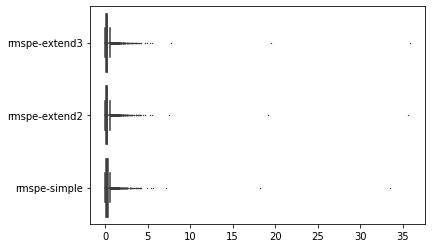

In [42]:
sns.boxplot(data=test[["rmspe-extend3", "rmspe-extend2", "rmspe-simple"]], orient="h", fliersize=0.5)

<AxesSubplot:>

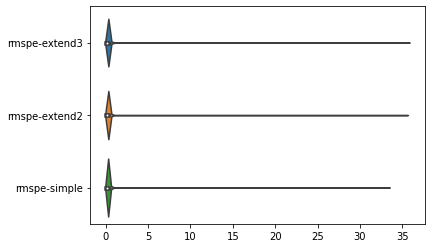

In [43]:
sns.violinplot(data=test[["rmspe-extend3", "rmspe-extend2", "rmspe-simple"]], orient="h", fliersize=0.5)

<AxesSubplot:>

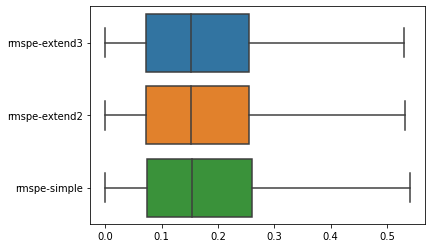

In [44]:
sns.boxplot(data=test[["rmspe-extend3", "rmspe-extend2", "rmspe-simple"]], orient="h", showfliers=False)

### Write Predictions to CSV

In [45]:
test = test.astype({'time_id': int, 'stock_id': int})
test.to_csv("extend3.csv", index=False)
test

,target_realized_volatility,predicted_volatility,time_id,stock_id,predicted_volatility600,predicted_volatility1200,rmspe-extend3,rmspe-extend2,rmspe-simple
0,0.004958,0.006033,207,0,0.005572,0.005977,0.216695,0.205349,0.123774
1,0.002072,0.002319,213,0,0.002461,0.002381,0.119007,0.148974,0.187857
2,0.003371,0.002404,266,0,0.002360,0.002433,0.286865,0.278122,0.299799
3,0.000741,0.000945,273,0,0.000927,0.000909,0.274874,0.226491,0.250947
4,0.001326,0.001637,465,0,0.001665,0.001663,0.234430,0.253792,0.255445
...,...,...,...,...,...,...,...,...,...
195269,0.002422,0.002281,32280,126,0.002326,0.002336,0.058234,0.035419,0.039480
195270,0.002960,0.002599,32361,126,0.002697,0.002598,0.122027,0.122339,0.088749
195271,0.012813,0.009737,32649,126,0.009466,0.009630,0.240035,0.248431,0.261200
195272,0.001959,0.002491,32662,126,0.002464,0.002493,0.271766,0.272765,0.258020


In [46]:
test = pd.read_csv("extend3.csv")
test

,target_realized_volatility,predicted_volatility,time_id,stock_id,predicted_volatility600,predicted_volatility1200,rmspe-extend3,rmspe-extend2,rmspe-simple
0,0.004958,0.006033,207,0,0.005572,0.005977,0.216695,0.205349,0.123774
1,0.002072,0.002319,213,0,0.002461,0.002381,0.119007,0.148974,0.187857
2,0.003371,0.002404,266,0,0.002360,0.002433,0.286865,0.278122,0.299799
3,0.000741,0.000945,273,0,0.000927,0.000909,0.274874,0.226491,0.250947
4,0.001326,0.001637,465,0,0.001665,0.001663,0.234430,0.253792,0.255445
...,...,...,...,...,...,...,...,...,...
195269,0.002422,0.002281,32280,126,0.002326,0.002336,0.058234,0.035419,0.039480
195270,0.002960,0.002599,32361,126,0.002697,0.002598,0.122027,0.122339,0.088749
195271,0.012813,0.009737,32649,126,0.009466,0.009630,0.240035,0.248431,0.261200
195272,0.001959,0.002491,32662,126,0.002464,0.002493,0.271766,0.272765,0.258020


## Model Feature Importance

In [47]:
import seaborn as sns

def plot_importance(importance, title='', save_to_file=None, top=None):    
    importance = importance.sort_values(
        ['Importance'], ascending=False
    )[:top]#.sort_values(['Importance'])
    sns.set(font_scale=1)

    plt.figure(figsize=(10, 8))
    #importance.plot.barh(ax=ax)
    sns.barplot(x="Importance", y="Features", data=importance.sort_values(by="Importance",ascending=False))
    
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_to_file:
        plt.savefig(save_to_file)
    plt.show()
    plt.close()

def compute_mean_importance(importance):
    res = importance[0].copy()
    res['Importance'] = np.mean(np.array(
        [df['importance'].values for df in importance]
    ), axis=0)
    
    res = res.drop(['importance'], axis=1)
    
    # reformat for plot
    return pd.DataFrame(
        {'Features':[f for f in res.index], 
         'Importance': res['Importance']}
    ).reset_index(drop=True)


### Plotting Importance by Gain & Split

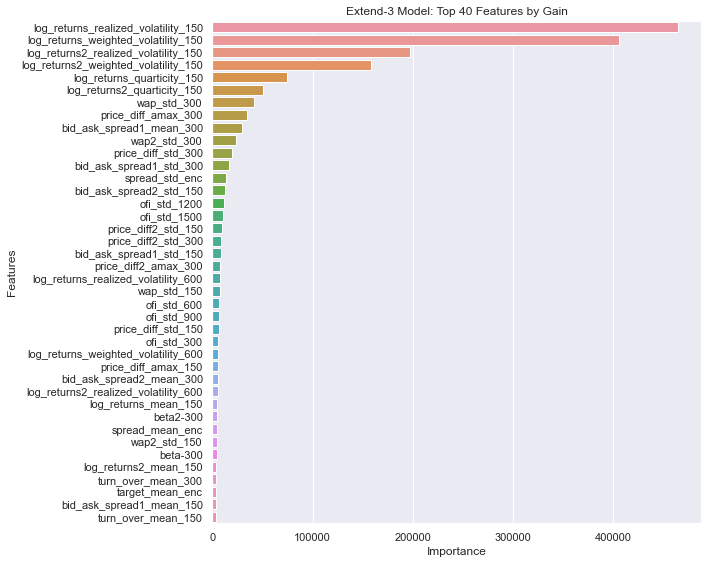

,Features,Importance
0,bid_ask_spread3_std_600,107.750676
1,dispersion_amax_1500,119.960838
2,wap_diff_std_1200,126.620170
3,wap_diff_amax_1500,135.246197
4,bid_ask_spread3_std_1200,142.800950
...,...,...
342,log_returns_quarticity_150,74395.077281
343,log_returns2_weighted_volatility_150,157805.961823
344,log_returns2_realized_volatility_150,197055.839703
345,log_returns_weighted_volatility_150,405982.950791


In [50]:
mean_gain = compute_mean_importance(gain_importance)

plot_importance(mean_gain, title='Extend-3 Model: Top 40 Features by Gain', top=40,
               save_to_file="importance_by_gain_extend3.png")

mean_gain

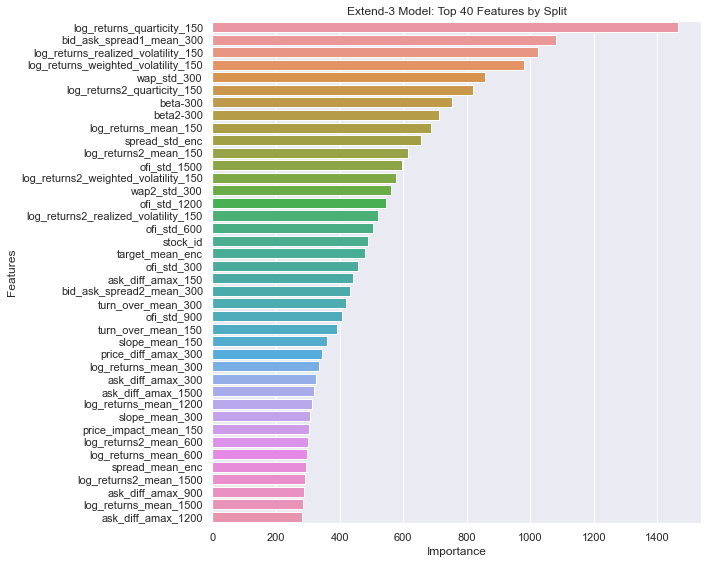

,Features,Importance
0,dispersion_amax_1500,28.56
1,wap_diff_std_900,31.24
2,bid_ask_spread3_std_600,32.52
3,wap_diff_amax_1500,33.88
4,wap_diff_std_1500,34.52
...,...,...
342,wap_std_300,858.24
343,log_returns_weighted_volatility_150,980.96
344,log_returns_realized_volatility_150,1024.44
345,bid_ask_spread1_mean_300,1079.80


In [58]:
mean_gain = compute_mean_importance(split_importance)

plot_importance(mean_gain, title='Extend-3 Model: Top 40 Features by Split', top=40,
               save_to_file="importance_by_split_extend3.png")

mean_gain

<AxesSubplot:>

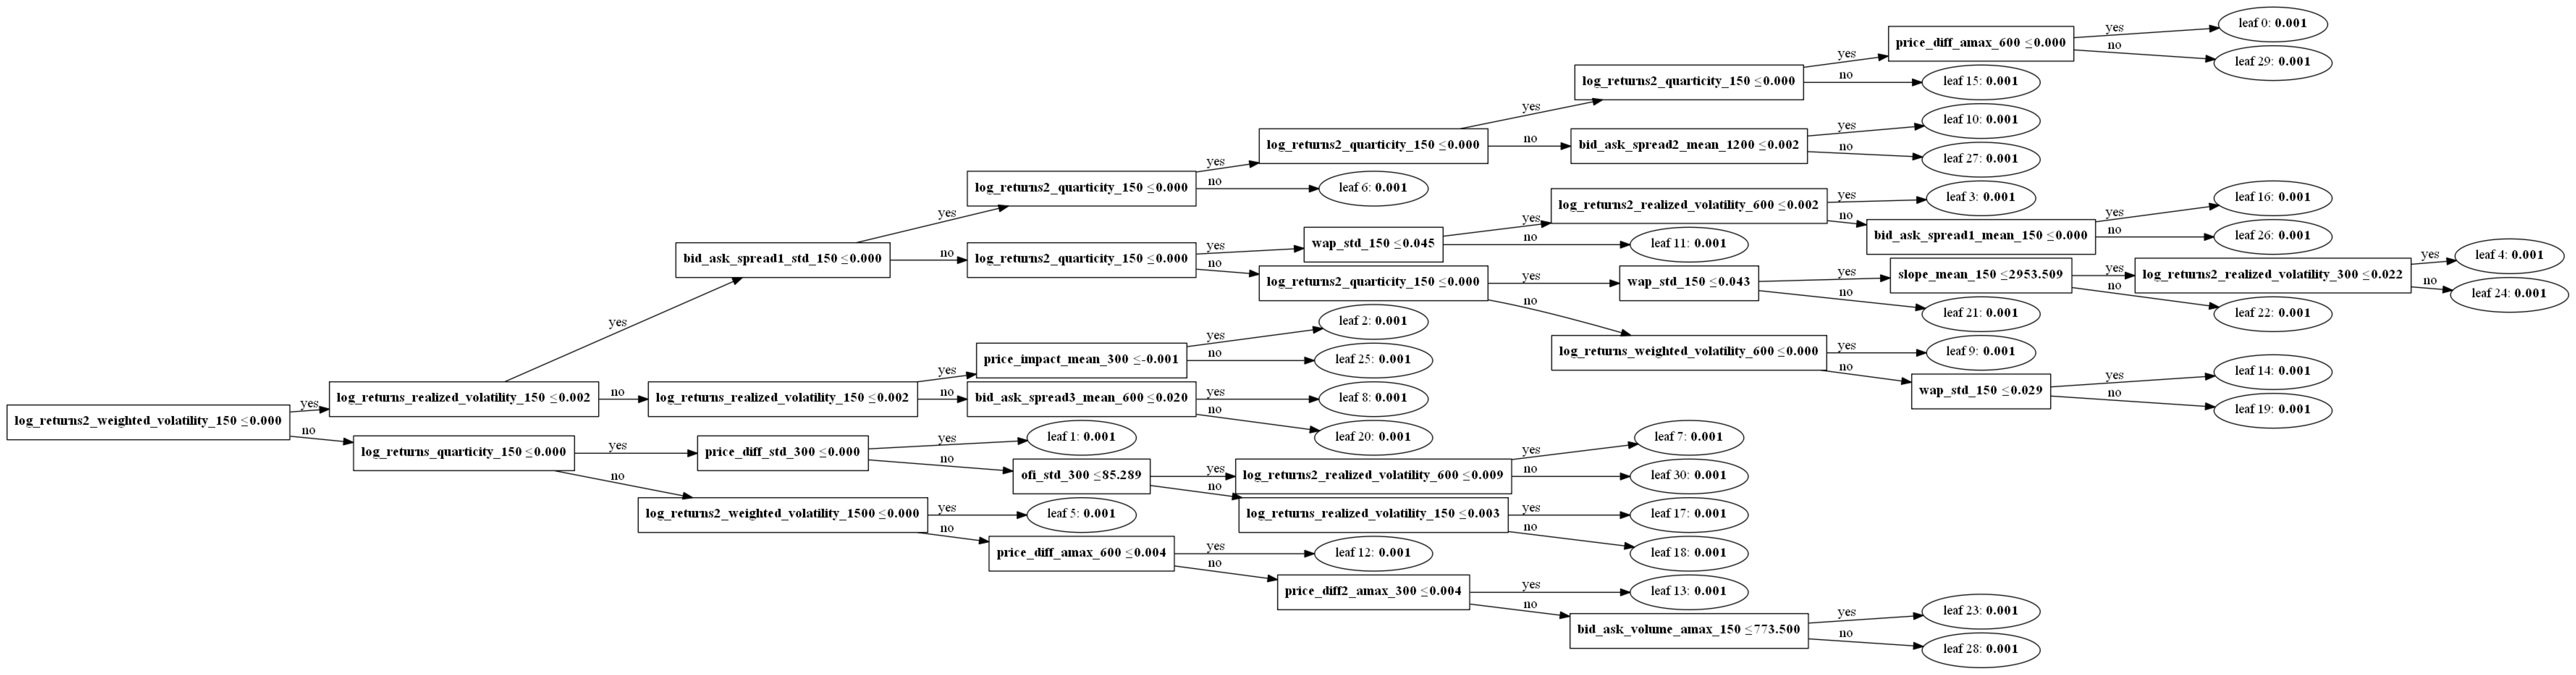

In [56]:
lgbm.plot_tree(models[0], tree_index = 0, figsize=(100,100))

## Post-Hoc ANOVA tests
https://statisticsbyjim.com/anova/post-hoc-tests-anova/ 

Every time we t-test the same data there is chance for a Type I error (i.e. reject null hypothesis when it is true), which is often the set significance level of 0.05. If we conduct multiple t-tests, Type I errors are accumulative. For two t-tests the chance for Type I error ~15% as seen in table below. Thus, we use ANOVA and post-hoc tests to control Type I error to always be 0.05 even with multiple comparisons.

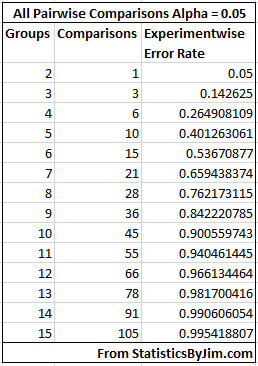

The experiment-wise error rate determines the probability of type I error (false positive) over a total family of comparisons. Our ANOVA example has 3 groups, which produces 3 comparisons and a family-wise error rate of 0.143. When performing statistical tests, we expect a false positive rate of 0.05 (our set significance level). As shown, when increasing groups from 2 to 3, the error rate is approximately tripled from 0.05 to 0.143. This introduces doubt as to whether we are observing a false positive as opposed to a significant difference.

If we use 2-sample t-tests to compare group means, and set a significance level of 0.05 for each test, then the number of comparisons will determine the experiment-wise error rate. In post hoc tests, we set an experiment-wise error rate for all comparisons, and the post hoc test calculates a significance level for individual comparisons to produce the specified familywise error rate.

In [75]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import tukey_hsd

### ANOVA F-Test

    Null: All group means are equal.
    Alternative: Not all group means are equal.


In [69]:
extend3 = test['rmspe-extend3']
extend2 = test['rmspe-extend2']
simple = test['rmspe-simple']

f_oneway(extend3, extend2, simple)

F_onewayResult(statistic=14.182812613379857, pvalue=6.928382608641173e-07)

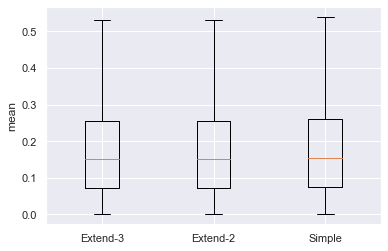

In [73]:
fig, ax = plt.subplots(1, 1)
ax.boxplot([extend3, extend2, simple], showfliers=False)
ax.set_xticklabels(["Extend-3", "Extend-2", "Simple"]) 
ax.set_ylabel("mean") 
plt.show()

Since p-val < 0.05, we have sufficient evidence that the mean values across each group are not equal.

### Tukey's Test

In [77]:
result = tukey_hsd(extend3, extend2, simple)
print(result)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.000     0.983    -0.002     0.001
 (0 - 2)     -0.003     0.000    -0.004    -0.001
 (1 - 0)      0.000     0.983    -0.001     0.002
 (1 - 2)     -0.003     0.000    -0.004    -0.001
 (2 - 0)      0.003     0.000     0.001     0.004
 (2 - 1)      0.003     0.000     0.001     0.004



In [66]:
tukey = pairwise_tukeyhsd(endog=df['score'],groups=df['group'],alpha=0.05)

Ttest_indResult(statistic=-0.17527821547612532, pvalue=0.8608611191788784)

In [87]:
df = pd.DataFrame({'rmspe':list(extend3)+list(extend2)+list(simple),
                   'model':np.repeat(['extend3','extend2','simple'], repeats=len(extend3))})

tukey = pairwise_tukeyhsd(endog=df['rmspe'],groups=df['model'],alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
extend2 extend3  -0.0001 0.9831 -0.0015 0.0013  False
extend2  simple   0.0027    0.0  0.0013 0.0041   True
extend3  simple   0.0028    0.0  0.0014 0.0042   True
-----------------------------------------------------


* P-val for difference in means between extend2 and extend3: 0.9831
* P-val for difference in means between extend2 and simple: ~0
* P-val for difference in means between extend3 and simple: ~0

Thus, we would conclude there is a statistically significant difference between means of extend3 and simple models and extend2 and simple models, but not a statistically significant difference between means of extend3 and extend2 models.

In [103]:
test_melt = pd.melt(test, value_vars=['rmspe-extend3', 'rmspe-extend2', 'rmspe-simple'])

test_melt.columns = ['model', 'value']
test_melt

,model,value
0,rmspe-extend3,0.216695
1,rmspe-extend3,0.119007
2,rmspe-extend3,0.286865
3,rmspe-extend3,0.274874
4,rmspe-extend3,0.234430
...,...,...
585817,rmspe-simple,0.039480
585818,rmspe-simple,0.088749
585819,rmspe-simple,0.261200
585820,rmspe-simple,0.258020


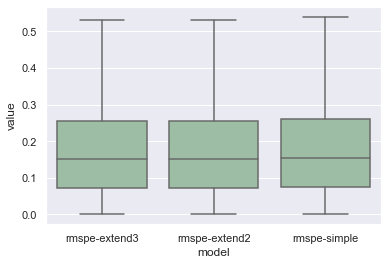

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='model', y='value', data=test_melt, color='#99c2a2', showfliers=False)

### Source: https://www.reneshbedre.com/blog/anova.html